Instalacja i ładowanie danych

In [ ]:
import tensorflow as tf
import os
import cv2
import imghdr
from google.colab import drive
import numpy as np
from matplotlib import pyplot as plt
import argparse
from keras.models import Sequential
from keras.layers import BatchNormalization
from keras.layers import Normalization, Resizing, RandomFlip, RandomRotation, RandomZoom
from keras.layers.core import Dense, Dropout, Flatten, Activation
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.regularizers import l2
from tensorflow.keras.metrics import Precision, Recall, SparseCategoricalAccuracy
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn import metrics
from keras.utils import plot_model

In [ ]:
labels = {'HSIL':0,'LSIL':1,'NSIL':2}
data_dir = "/content/gdrive/MyDrive/Colab Notebooks/Data/"
drive.mount('/content/gdrive')

In [ ]:
data = tf.keras.utils.image_dataset_from_directory("/content/gdrive/MyDrive/Colab Notebooks/Data/", labels='inferred', image_size=(256, 256))

Found 918 files belonging to 3 classes.


In [ ]:
data_iterator = data.as_numpy_iterator()

In [ ]:
batch = data_iterator.next()

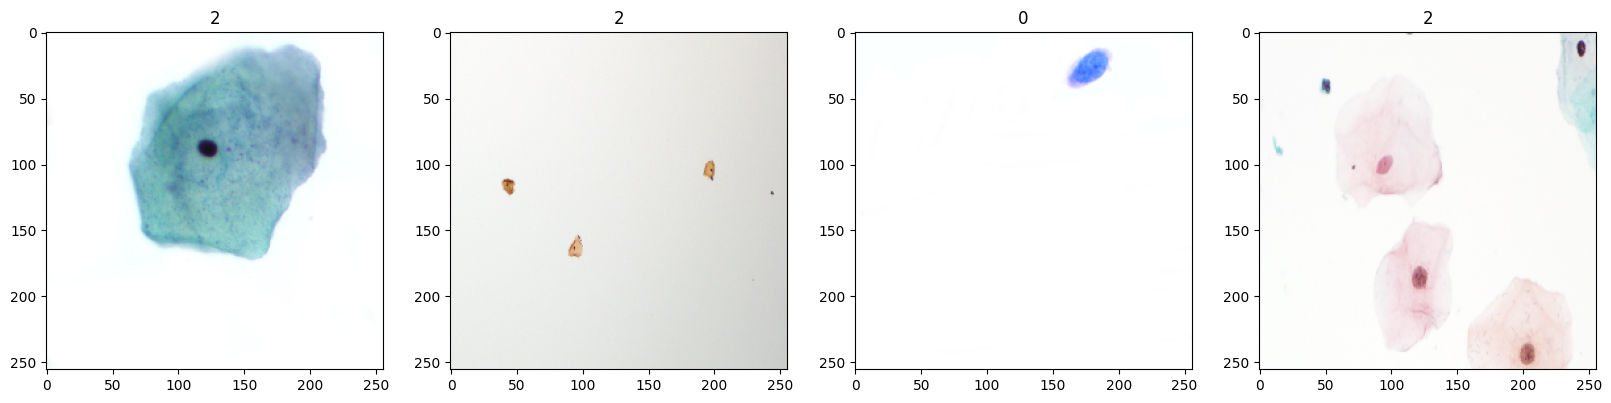

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [ ]:
data = data.map(lambda x,y: (x/255, y))

In [ ]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.1)
test_size = int(len(data)*.2)

In [ ]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [ ]:
img_shape = (256, 256, 3)
n_classes = 3

In [ ]:
model = Sequential()
model.add(Normalization())
model.add(Resizing(256, 256))
model.add(RandomFlip("horizontal"))
model.add(RandomRotation(factor=0.02))
model.add(RandomZoom(height_factor=0.2, width_factor=0.2))
model.add(Conv2D(32, (3,3), 1, activation='relu', input_shape=img_shape))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(n_classes, activation='softmax'))

In [ ]:
model.compile('adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

In [ ]:
logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [ ]:
cnn = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
20/20 [==============================] - 296s 13s/step - loss: 0.7768 - accuracy: 0.6422 - val_loss: 0.7737 - val_accuracy: 0.6094
Epoch 2/20
20/20 [==============================] - 227s 10s/step - loss: 0.7789 - accuracy: 0.6906 - val_loss: 0.7464 - val_accuracy: 0.7344
Epoch 3/20
20/20 [==============================] - 212s 9s/step - loss: 0.6868 - accuracy: 0.6953 - val_loss: 0.5282 - val_accuracy: 0.8125
Epoch 4/20
20/20 [==============================] - 271s 13s/step - loss: 0.6031 - accuracy: 0.7469 - val_loss: 0.5982 - val_accuracy: 0.7656
Epoch 5/20
20/20 [==============================] - 214s 10s/step - loss: 0.6482 - accuracy: 0.7563 - val_loss: 0.5932 - val_accuracy: 0.7344
Epoch 6/20
20/20 [==============================] - 269s 13s/step - loss: 0.6955 - accuracy: 0.6812 - val_loss: 0.5322 - val_accuracy: 0.8594
Epoch 7/20
20/20 [==============================] - 206s 9s/step - loss: 0.5755 - accuracy: 0.7734 - val_loss: 0.5214 - val_accuracy: 0.7500
Epoch 8/

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 256, 256, 3)      7         
 n)                                                              
                                                                 
 resizing (Resizing)         (None, 256, 256, 3)       0         
                                                                 
 random_flip (RandomFlip)    (None, 256, 256, 3)       0         
                                                                 
 random_rotation (RandomRota  (None, 256, 256, 3)      0         
 tion)                                                           
                                                                 
 random_zoom (RandomZoom)    (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      8

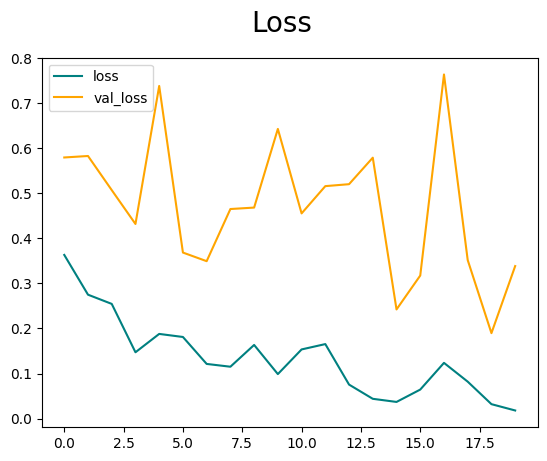

In [ ]:
fig = plt.figure()
plt.plot(cnn.history['loss'], color='teal', label='loss')
plt.plot(cnn.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

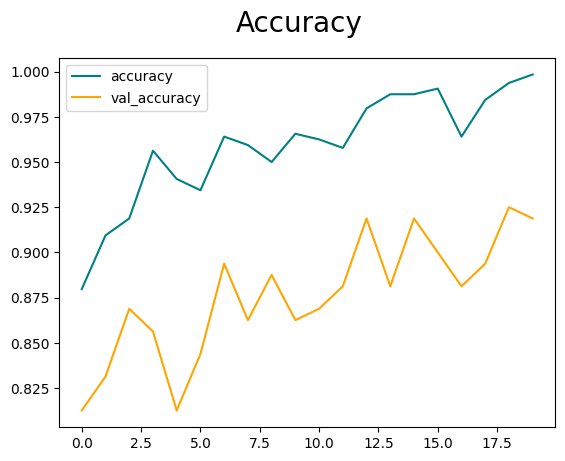

In [ ]:
fig = plt.figure()
plt.plot(cnn.history['accuracy'], color='teal', label='accuracy')
plt.plot(cnn.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [ ]:
cnn.save(os.path.join("/content/gdrive/MyDrive/Colab Notebooks/models",'simple_CNN_10.06.h5'))

In [ ]:
def testing(model):
  pre = Precision()
  re = Recall()
  acc = SparseCategoricalAccuracy()
  pred = []
  y_test = []
  for batch in test.as_numpy_iterator(): 
    X, y = batch
    y_test.append(y)
    yhat = np.argmax(model.predict(X), axis=1)
    pred.append(yhat)
    xy=model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, xy)

  pred = np.array(pred)
  pred = pred.reshape((pred.size,))
  y_test = np.array(y_test)
  y_test = y_test.reshape((y_test.size,))
  print(accuracy_score(y_test, pred))
  ConfusionMatrixDisplay.from_predictions(y_test, pred)
  tf.keras.utils.plot_model(model,show_shapes=True)
  print(classification_report(y_test, pred, target_names=labels))

1/1 [==============================] - 1s 834ms/step
0.86875
              precision    recall  f1-score   support

        HSIL       0.83      0.87      0.85        45
        LSIL       0.73      0.71      0.72        31
        NSIL       0.94      0.93      0.93        84

    accuracy                           0.87       160
   macro avg       0.83      0.83      0.83       160
weighted avg       0.87      0.87      0.87       160



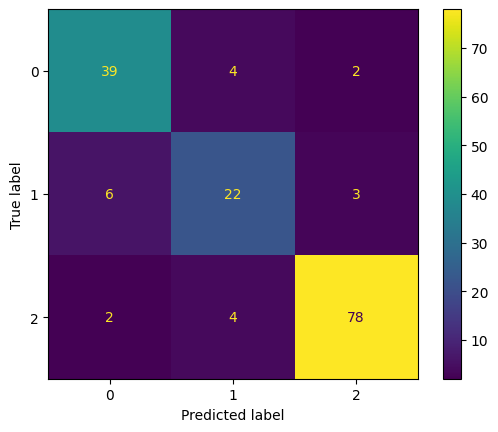

In [ ]:
testing(model)